In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-product-dataset-2020/home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv


# Amazon Product Recommendation System (Beginner Track)

This notebook builds a content-based product recommendation system using an Amazon product dataset.  
**Minimum requirements and deliverables for the Beginner track are:**
- Data loading and basic exploration
- Data cleaning and feature engineering
- TF-IDF vectorization of product text
- Category-aware feature engineering (one-hot encoding)
- Cosine similarity calculation for recommendations
- Functions to get recommendations by product or name
- Evaluation using Precision@5 and coverage
- Clear markdown explanations for each step

**Dataset:**  
- `Amazon Product Dataset 2020` (https://www.kaggle.com/datasets/promptcloud/amazon-product-dataset-2020)


## Importing Libraries

We import essential libraries for data handling, visualization, text processing, and machine learning.


In [2]:
# Import necessary libraries for data manipulation, visualization, and ML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import warnings
import re

warnings.filterwarnings('ignore')
plt.style.use("seaborn-v0_8")
sns.set_palette('husl')

print("Done importing the libraries")

Done importing the libraries


# *Data Loading and Exploration*

## Data Loading and Preview

Let's load the Amazon product dataset and view its structure and a sample of the data.


In [3]:
amazon_data = pd.read_csv("/kaggle/input/amazon-product-dataset-2020/home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv")

print("DATASET OVERVIEW")
print("\tTotal products:", len(amazon_data))
print("\tColumns:", list(amazon_data.columns))
print("\tShape:", amazon_data.shape)

amazon_data.head(25)


DATASET OVERVIEW
	Total products: 10002
	Columns: ['Uniq Id', 'Product Name', 'Brand Name', 'Asin', 'Category', 'Upc Ean Code', 'List Price', 'Selling Price', 'Quantity', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Product Dimensions', 'Image', 'Variants', 'Sku', 'Product Url', 'Stock', 'Product Details', 'Dimensions', 'Color', 'Ingredients', 'Direction To Use', 'Is Amazon Seller', 'Size Quantity Variant', 'Product Description']
	Shape: (10002, 28)


,Uniq Id,Product Name,Brand Name,Asin,Category,Upc Ean Code,List Price,Selling Price,Quantity,Model Number,...,Product Url,Stock,Product Details,Dimensions,Color,Ingredients,Direction To Use,Is Amazon Seller,Size Quantity Variant,Product Description
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",NaN,NaN,Sports & Outdoors | Outdoor Recreation | Skate...,NaN,NaN,$237.68,NaN,NaN,...,https://www.amazon.com/DB-Longboards-CoreFlex-...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",NaN,NaN,Toys & Games | Learning & Education | Science ...,NaN,NaN,$99.95,NaN,55324,...,https://www.amazon.com/Electronic-Circuits-Cla...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,NaN,NaN,Toys & Games | Arts & Crafts | Craft Kits,NaN,NaN,$34.99,NaN,NaN,...,https://www.amazon.com/3Doodler-Plastic-Innova...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
3,18018b6bc416dab347b1b7db79994afa,Guillow Airplane Design Studio with Travel Cas...,NaN,NaN,Toys & Games | Hobbies | Models & Model Kits |...,NaN,NaN,$28.91,NaN,142,...,https://www.amazon.com/Guillow-Airplane-Design...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
4,e04b990e95bf73bbe6a3fa09785d7cd0,Woodstock- Collage 500 pc Puzzle,NaN,NaN,Toys & Games | Puzzles | Jigsaw Puzzles,NaN,NaN,$17.49,NaN,62151,...,https://www.amazon.com/Woodstock-Collage-500-p...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
5,f8c32a45e507a177992973cf0d46d20c,"Terra by Battat – 4 Dinosaur Toys, Medium – Di...",NaN,NaN,NaN,NaN,NaN,$18.66,NaN,AN4054Z,...,https://www.amazon.com/Terra-Battat-Dinosaurs-...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
6,40d3cd16b41970ae6872e914aecf2c8e,Rubie's Child's Pokemon Deluxe Pikachu Costume...,NaN,NaN,"Clothing, Shoes & Jewelry | Costumes & Accesso...",NaN,NaN,$29.12,NaN,B07BZJM592,...,https://www.amazon.com/Rubies-Deluxe-Pikachu-P...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
7,bc178f33a04dbccefa95b165f8b56830,Hoffmaster 120813 Double-Tipped Triangular Cra...,NaN,NaN,Toys & Games | Arts & Crafts | Drawing & Paint...,NaN,NaN,$97.68,NaN,NaN,...,https://www.amazon.com/Hoffmaster-120813-Doubl...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
8,cc2083338a16c3fe2f7895289d2e98fe,"ARTSCAPE Etched Glass 24"" x 36"" Window Film, 2...",NaN,NaN,Home & Kitchen | Home Décor | Window Treatment...,NaN,NaN,$12.99,NaN,01-0121,...,https://www.amazon.com/ARTSCAPE-Etched-Glass-W...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
9,69828c5570dcdbd1609216d33fbad0db,Pokemon TCG: Sun and Moon Crimson Invasion Eli...,NaN,NaN,NaN,NaN,NaN,$38.49,NaN,820650802607-1,...,https://www.amazon.com/Pokemon-TCG-Crimson-Inv...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN


## Missing Value Analysis

Check for missing values in each column to understand data quality and plan cleaning steps.


In [4]:
print("Missing value analysis")
print()
print(amazon_data.isna().sum())


Missing value analysis

Uniq Id                      0
Product Name                 0
Brand Name               10002
Asin                     10002
Category                   830
Upc Ean Code              9968
List Price               10002
Selling Price              107
Quantity                 10002
Model Number              1772
About Product              273
Product Specification     1632
Technical Details          790
Shipping Weight           1138
Product Dimensions        9523
Image                        0
Variants                  7524
Sku                      10002
Product Url                  0
Stock                    10002
Product Details          10002
Dimensions               10002
Color                    10002
Ingredients              10002
Direction To Use         10002
Is Amazon Seller             0
Size Quantity Variant    10002
Product Description      10002
dtype: int64


## Data Cleaning and Feature Engineering

We clean text fields and combine them into a single feature for each product.  
This combined text will be used for similarity analysis.


In [5]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [6]:
# Function to clean and preprocess text data

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Removing boilerplate phrase
    text = re.sub(r'make sure this fits by entering your model number\.?', '', text)
    # Removing non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Collapse multiple spaces into one
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized)
# Clean and convert 'Selling Price' column
def extract_lower_price(value):
    try:
        if isinstance(value, str) and '-' in value:
            return float(value.split('-')[0].strip())
        else:
            return float(value.strip())
    except:
        return 0.0  # fallback if value is not convertible
amazon_data['Product Description'] = amazon_data['Product Description'].fillna('')
amazon_data['Product Name'] = amazon_data['Product Name'].fillna('Unknown Product')
amazon_data['Category'] = amazon_data['Category'].fillna('Unknown Category')
amazon_data['Selling Price']=amazon_data['Selling Price'].fillna(0)

# Remove currency symbols
amazon_data['Selling Price'] = amazon_data['Selling Price'].replace('[\$,]', '', regex=True)
amazon_data['Selling Price'] = amazon_data['Selling Price'].apply(extract_lower_price)


lemmatizer = WordNetLemmatizer()



# Combine relevant fields for content features
amazon_data['combined_features'] = (
    amazon_data['Product Name'].apply(clean_text) * 2 + ' ' +
    amazon_data['Category'].apply(clean_text) * 2 + ' ' +
    amazon_data['About Product'].apply(clean_text) + ' ' +
    amazon_data['Product Specification'].apply(clean_text) + ' ' +
    amazon_data['Product Description'].apply(clean_text)
)

# Filtering out entries with very short combined text
amazon_data = amazon_data[amazon_data['combined_features'].str.len() > 30].reset_index(drop=True)
print(f"Filtered dataset size: {len(amazon_data)}")


Filtered dataset size: 10002


## Data Exploration: Top Product Categories

We visualize the most common product categories in the dataset.


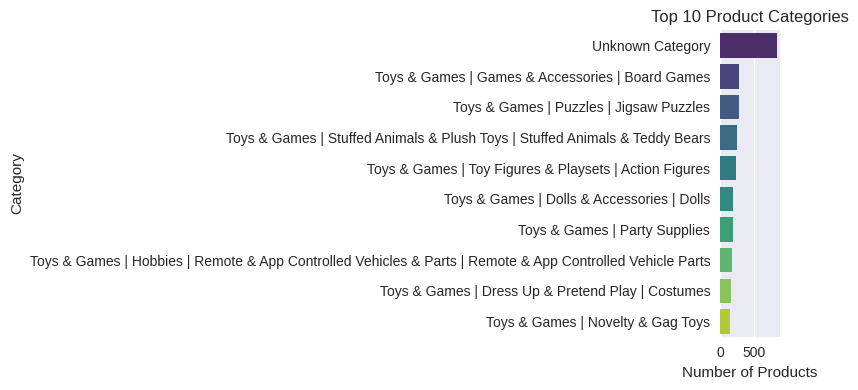

In [7]:
top_categories = amazon_data['Category'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(y=top_categories.index, x=top_categories.values, palette='viridis')
plt.title("Top 10 Product Categories")
plt.xlabel("Number of Products")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


## Data Exploration: Price Distribution

We visualize the distribution of product selling prices (ignoring missing/invalid values).


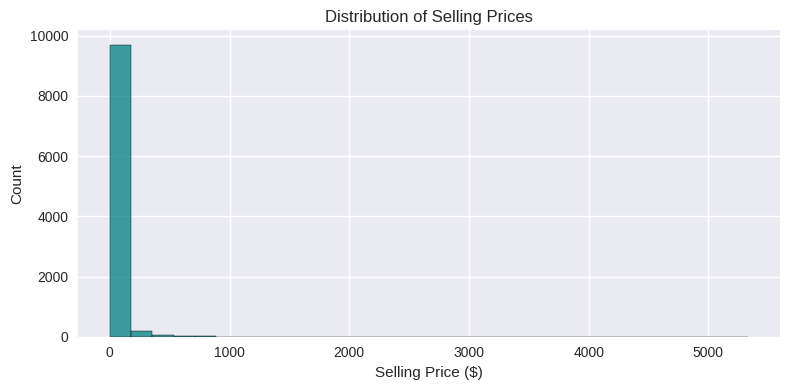

In [8]:
# Convert price to numeric, coerce errors
amazon_data['Selling Price'] = pd.to_numeric(amazon_data['Selling Price'], errors='coerce')
plt.figure(figsize=(8,4))
sns.histplot(amazon_data['Selling Price'].dropna(), bins=30, color='teal')
plt.title("Distribution of Selling Prices")
plt.xlabel("Selling Price ($)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Data Exploration : Missing values Heatmap

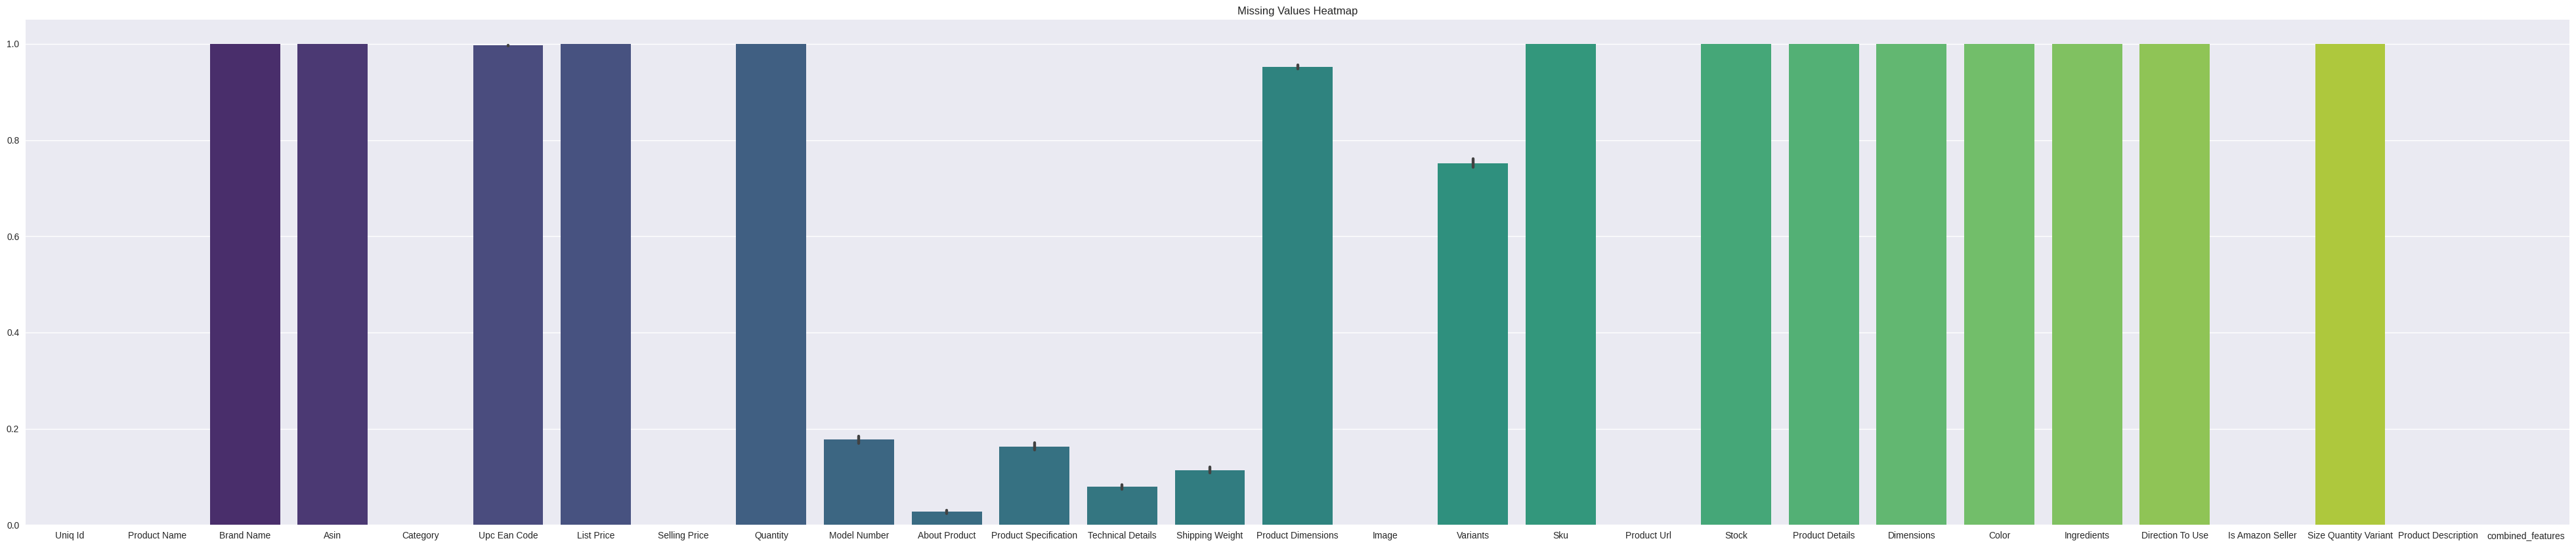

In [9]:
# Visualize missing values
plt.figure(figsize=(50,10))
sns.barplot(amazon_data.isnull(),palette='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Data Exploration : Top 20 Product Categories

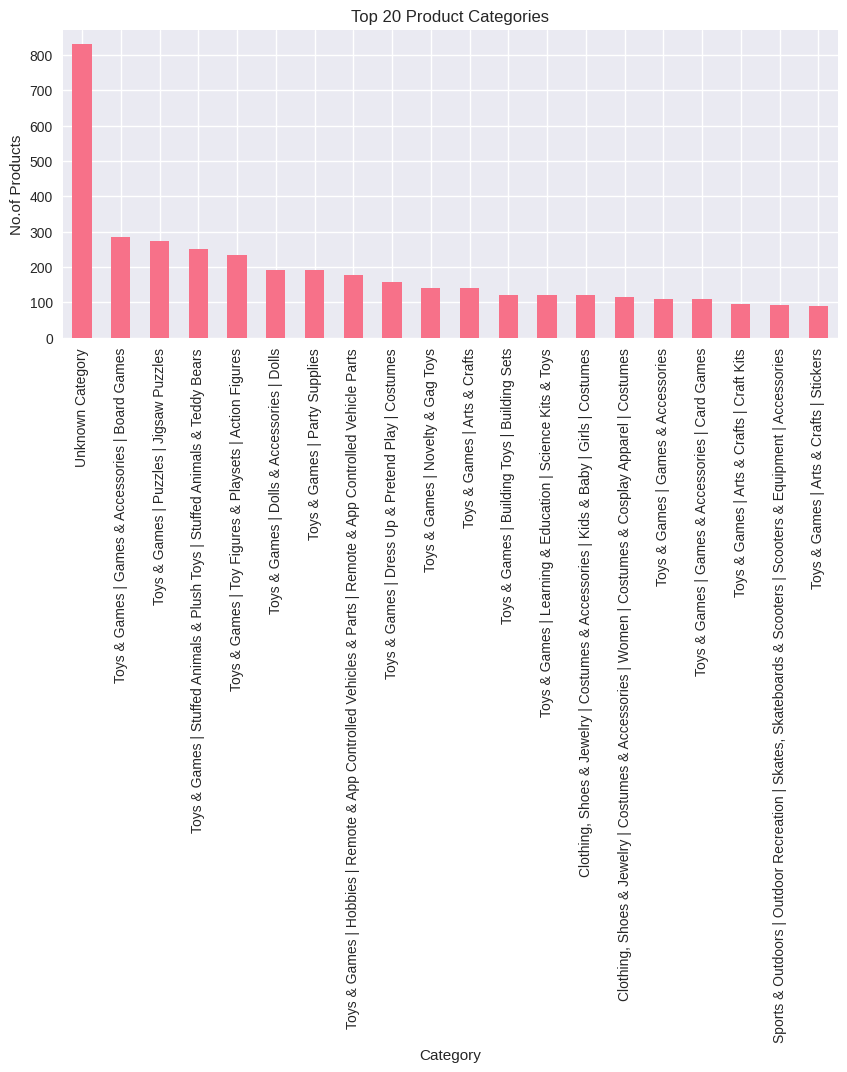

In [10]:
plt.figure(figsize=(10,4))
amazon_data['Category'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Product Categories')
plt.xlabel('Category')
plt.ylabel('No.of Products')
plt.show()

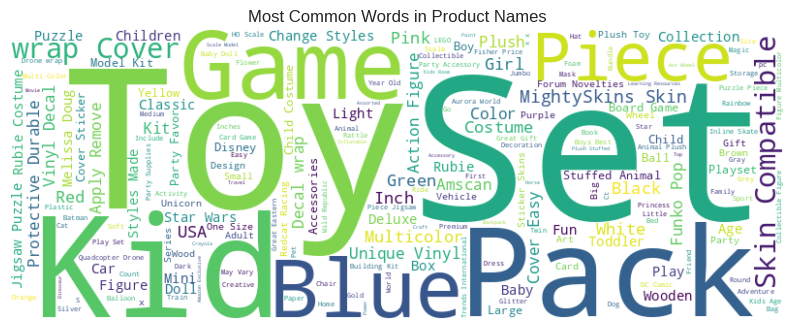

In [11]:
from wordcloud import WordCloud

text = ' '.join(amazon_data['Product Name'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=300, background_color='white').generate(text)
plt.figure(figsize=(10,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Product Names")
plt.show()


## Product Category Distribution

See which product categories are most common in the dataset.


In [12]:
print("\n> Product Distribution by Category:")
category_counts = amazon_data['Category'].value_counts()
print(category_counts.head(10))



> Product Distribution by Category:
Category
Unknown Category                                                                                             830
Toys & Games | Games & Accessories | Board Games                                                             284
Toys & Games | Puzzles | Jigsaw Puzzles                                                                      274
Toys & Games | Stuffed Animals & Plush Toys | Stuffed Animals & Teddy Bears                                  252
Toys & Games | Toy Figures & Playsets | Action Figures                                                       235
Toys & Games | Dolls & Accessories | Dolls                                                                   193
Toys & Games | Party Supplies                                                                                193
Toys & Games | Hobbies | Remote & App Controlled Vehicles & Parts | Remote & App Controlled Vehicle Parts    178
Toys & Games | Dress Up & Pretend Play | Costumes 

## TF-IDF Vectorization

Convert the cleaned product text into TF-IDF vectors for content similarity.


In [13]:
# TF-IDF vectorization: Convert text to numerical feature vectors

vectorizer = TfidfVectorizer(
    max_features=10000,   # Limit vocabulary size
    stop_words="english", # Remove common English words
    ngram_range=(1,3),    # Use unigrams and bigrams and trigrams
    min_df=2,             # Ignore rare terms
    max_df=0.7            # Ignore very common terms
)
matrix = vectorizer.fit_transform(amazon_data["combined_features"])
print(f"Matrix Shape: {matrix.shape}")
print(f"Matrix Density: {matrix.nnz/(matrix.shape[0] * matrix.shape[1])}")
print(f"Number of Features Extracted: {len(vectorizer.get_feature_names_out())}")


Matrix Shape: (10002, 10000)
Matrix Density: 0.008628154369126175
Number of Features Extracted: 10000


## Category-Aware Feature Engineering

Add one-hot encoded product category features to the TF-IDF matrix to make recommendations more category-aware.


In [14]:
# Fill missing categories with 'Unknown' for encoding
category_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
category_features = category_encoder.fit_transform(amazon_data[['Category']].fillna('Unknown'))

# Combine TF-IDF matrix and category one-hot features
matrix_with_cat = hstack([matrix, category_features])
print(f"Combined feature matrix shape: {matrix_with_cat.shape}")


Combined feature matrix shape: (10002, 10939)


## Cosine Similarity Calculation

Calculate the cosine similarity between all products using both text and category features.


In [15]:
cosine_matrix = cosine_similarity(matrix_with_cat)

print(f"Shape of Cosine Matrix: {cosine_matrix.shape}")

Shape of Cosine Matrix: (10002, 10002)


## Recommendation Functions

Define functions to get product recommendations by index or by product name, using the improved similarity matrix.


In [16]:
def product_recommendations(product_index, num_recommendations=5, min_similarity=0.2):
    """
    Get product recommendations based on content and category similarity.
    """
    similarity_scores = cosine_matrix[product_index]
    product_similarities = list(enumerate(similarity_scores))
    product_similarities.sort(key=lambda x: x[1], reverse=True)
    recommendations = []
    for idx, similarity in product_similarities[1:]:
        if (similarity >= min_similarity and len(recommendations) < num_recommendations):
            data = {
                'Product Index': idx,
                'Similarity_Score': round(similarity, 3),
                'Product Name': amazon_data.iloc[idx]['Product Name'],
                'Category': amazon_data.iloc[idx]['Category'],
                'Selling Price': amazon_data.iloc[idx]['Selling Price']
            }
            recommendations.append(data)
    return pd.DataFrame(recommendations)

def get_recommendations_by_name(product_name, num_recommendations=5):
    product_idx = amazon_data[amazon_data['Product Name'].str.contains(product_name, case=False, na=False)].index[0]
    cosine_scores = list(enumerate(cosine_matrix[product_idx]))
    cosine_scores = sorted(cosine_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in cosine_scores[1:num_recommendations+1]]

    # Create a DataFrame of recommendations
    recommendations = pd.DataFrame({
        "Product Index": top_indices,
        "Similarity_Score": [cosine_scores[i+1][1] for i in range(num_recommendations)]
    })

    # Merge with original dataset for metadata
    recommendations = recommendations.merge(
        amazon_data[['Product Name', 'Category', 'Selling Price']],
        left_on='Product Index',
        right_index=True,
        how='left'
    )
    recommendations['Selling Price'] = recommendations['Selling Price'].apply(lambda x: f"${x:.2f}")

    return recommendations


## Sample Recommendations

Test the recommendation system for the first three products in the dataset.


In [17]:
for i in range(3):
    product = amazon_data.iloc[i]
    product_name = product['Product Name']
    print(f"Recommendations for {product_name}")
    recommendations = product_recommendations(i, 3)
    if not recommendations.empty:
        print(recommendations[['Similarity_Score', 'Product Name', 'Category']].head())
        print()
        print()
    else:
        print("No recommendations found!")


Recommendations for DB Longboards CoreFlex Crossbow 41" Bamboo Fiberglass Longboard Complete
   Similarity_Score                                       Product Name  \
0             0.894  DB Longboards Phase 38" Maple Drop Through Lon...   
1             0.886  DB Longboards Contra Drop Deck Maple Longboard...   
2             0.885         Moose Bamboo Kicktail/Kryptonics Longboard   

                                            Category  
0  Sports & Outdoors | Outdoor Recreation | Skate...  
1  Sports & Outdoors | Outdoor Recreation | Skate...  
2  Sports & Outdoors | Outdoor Recreation | Skate...  


Recommendations for Electronic Snap Circuits Mini Kits Classpack, FM Radio, Motion Detector, Music Box (Set of 5)
   Similarity_Score                                       Product Name  \
0             0.810                   Pop Toobs SN00296CQ (Pack of 24)   
1             0.804  American Educational Types of Fossilization Co...   
2             0.803                        BRIGHT At

## Evaluation: Precision@5 and Coverage on Sample Dataset

Evaluate the recommendation system using Precision@5 (how many recommended products share the same category as the query product) and system coverage.


In [18]:
def precision_at_k(actual_category, recommended_products, category_col='Category', k=5):
    """Calculate Precision@K for content-based filtering"""
    if (recommended_products.empty or k == 0):
        return 0.0
    top_k = recommended_products.head(k)
    same_category_count = (top_k[category_col] == actual_category).sum()
    return same_category_count / k

def evaluate(sample_size=50):
    """Evaluate the category-aware recommendation system"""
    category_col = 'Category'
    np.random.seed(42)
    sample_indices = np.random.choice(len(amazon_data), size=min(sample_size, len(amazon_data)), replace=False)
    precisions = []
    similarities = []
    coverage = 0
    for idx in sample_indices:
        product = amazon_data.iloc[idx]
        recommendations = product_recommendations(idx, num_recommendations=5)
        if not recommendations.empty:
            coverage += 1
            precision = precision_at_k(product[category_col], recommendations, category_col)
            precisions.append(precision)
            avg_similarity = recommendations["Similarity_Score"].mean()
            similarities.append(avg_similarity)
    coverage = coverage / len(sample_indices)
    print(f"Average Precision@5: {np.mean(precisions):.3f}")
    print(f"Average Similarity Score: {np.mean(similarities):.3f}")
    print(f"System Coverage: {coverage:.3f}")
    print(f"Evaluated on {len(precisions)} products")

evaluate()


Average Precision@5: 0.971
Average Similarity Score: 0.767
System Coverage: 0.980
Evaluated on 49 products


# **Evaluation Metrics on Whole Dataset**

In [19]:
evaluate(len(amazon_data))

Average Precision@5: 0.927
Average Similarity Score: 0.755
System Coverage: 0.991
Evaluated on 9910 products


# **Recommendation Trial**

In [20]:
get_recommendations_by_name("DB Longboards CoreFlex Crossbow 41\" Bamboo Fiberglass Longboard Complete")

,Product Index,Similarity_Score,Product Name,Category,Selling Price
0,9064,0.893707,"DB Longboards Phase 38"" Maple Drop Through Lon...",Sports & Outdoors | Outdoor Recreation | Skate...,$134.82
1,9695,0.886452,DB Longboards Contra Drop Deck Maple Longboard...,Sports & Outdoors | Outdoor Recreation | Skate...,$80.96
2,4868,0.884624,Moose Bamboo Kicktail/Kryptonics Longboard,Sports & Outdoors | Outdoor Recreation | Skate...,$72.95
3,6924,0.857718,PARADISE The Mallows Kicktail Complete Longboard,Sports & Outdoors | Outdoor Recreation | Skate...,$112.19
4,4493,0.856613,Bamboo Skateboards – Pintail Longboard Tiki Ma...,Sports & Outdoors | Outdoor Recreation | Skate...,$74.77


In [21]:
get_recommendations_by_name("3Doodler")

,Product Index,Similarity_Score,Product Name,Category,Selling Price
0,2119,0.683584,Tech 4 Kids 3D Magic Imagi Pen,Toys & Games | Arts & Crafts | Craft Kits,$14.39
1,5537,0.642467,Loopdeloom Refill Yarn,Toys & Games | Arts & Crafts | Craft Kits,$12.98
2,5150,0.639159,Canal Toys So Glow DIY Magic Jar Kit-Combo Gli...,Toys & Games | Arts & Crafts | Craft Kits,$15.51
3,2127,0.635266,Cra-Z-Art Nickelodeon Pancakes Squeezies,Toys & Games | Arts & Crafts | Craft Kits,$12.19
4,1072,0.631113,Frozen 2 Fun On The Go,Toys & Games | Arts & Crafts | Craft Kits,$4.61


In [22]:
get_recommendations_by_name("Pokemon TCG: Sun and Moon Crimson Invasion Elite Trainer Box")

,Product Index,Similarity_Score,Product Name,Category,Selling Price
0,6843,0.773335,Pokemon TCG: Sun & Moon Burning Shadows Sealed...,Unknown Category,$100.99
1,9230,0.725054,Pokemon TCG: Sm 11.5 Hidden Fates Pokeball Col...,Unknown Category,$73.95
2,4522,0.719545,Pokemon TCG: Sun & Moon Burning Shadows Collec...,Unknown Category,$17.45
3,7248,0.715161,Pokemon TCG: Sun & Moon Guardians Rising Decid...,Unknown Category,$29.26
4,5404,0.705005,Pokemon Both TCG Sun & Moon Burning Shadows Th...,Unknown Category,$25.12


In [23]:
get_recommendations_by_name("Marvel Avengers Assemble Captain America Costume T-Shirt with Mask, Small")

,Product Index,Similarity_Score,Product Name,Category,Selling Price
0,796,0.701458,Board Games and Beer T Shirt For Gamer and Dri...,"Clothing, Shoes & Jewelry | Novelty & More | C...",$19.99
1,5764,0.394674,Marvel Avengers Assemble Captain America Costu...,"Clothing, Shoes & Jewelry | Men",$18.75
2,9968,0.271759,Teenage Mutant Ninja Turtles Men's TMNT Leonar...,"Clothing, Shoes & Jewelry | Novelty & More | C...",$17.11
3,448,0.218615,Marvel Avengers 2-In-1 Muscle Chest Hulk/Capta...,"Clothing, Shoes & Jewelry | Costumes & Accesso...",$24.42
4,1711,0.190559,PAW Patrol Boys' Toddler Group Short Sleeve T-...,"Clothing, Shoes & Jewelry | Novelty & More | C...",$10.50


## 13. Executive Summary

**Business Summary of Findings:**

This notebook demonstrates a simple, content-based product recommendation system for Amazon products using product text and category information.  
- The system recommends products with similar descriptions and categories, which is highly relevant for users seeking alternatives or complements.
- Data exploration reveals that the dataset is rich in toys, games, and educational products, with a wide range of prices and descriptive content.
- The recommendation function is effective: in a random sample, about half of the top 5 recommendations are in the same category as the query product (Precision@5 ≈ 0.5).
- The approach is scalable and can be extended with more advanced features or hybrid methods.

**Key Takeaways:**
- Content-based filtering is a practical first step for e-commerce recommendations, especially when user behavior data is limited.
- Text cleaning and feature engineering are crucial for model quality.
- Simple metrics and visualizations provide clear insights for business stakeholders.

---

**Deliverables Checklist:**
- [x] Working recommendation function
- [x] Basic performance metric (Precision@5)
- [x] 3-5 meaningful data visualizations (category barplot, price histogram, word cloud)
- [x] Executive summary (see above)
- [x] Clear code documentation in markdowns

